# Tree Models for Natural Fires

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import queries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df_fires = queries.get_df_fires()

df_fires_encoded = pd.get_dummies(df_fires.drop(['fire_size_class'], axis=1), columns=['month'])
scaler = StandardScaler()
scaler.fit(df_fires_encoded)

X = scaler.transform(df_fires_encoded)
y = df_fires.fire_size_class > ''

num_fires = (y == True).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}')

92659 fires out of 192659 data points
No fires 52.0% of the time
X_train: 144494, X_test: 48165, y_train: 144494, y_test: 48165


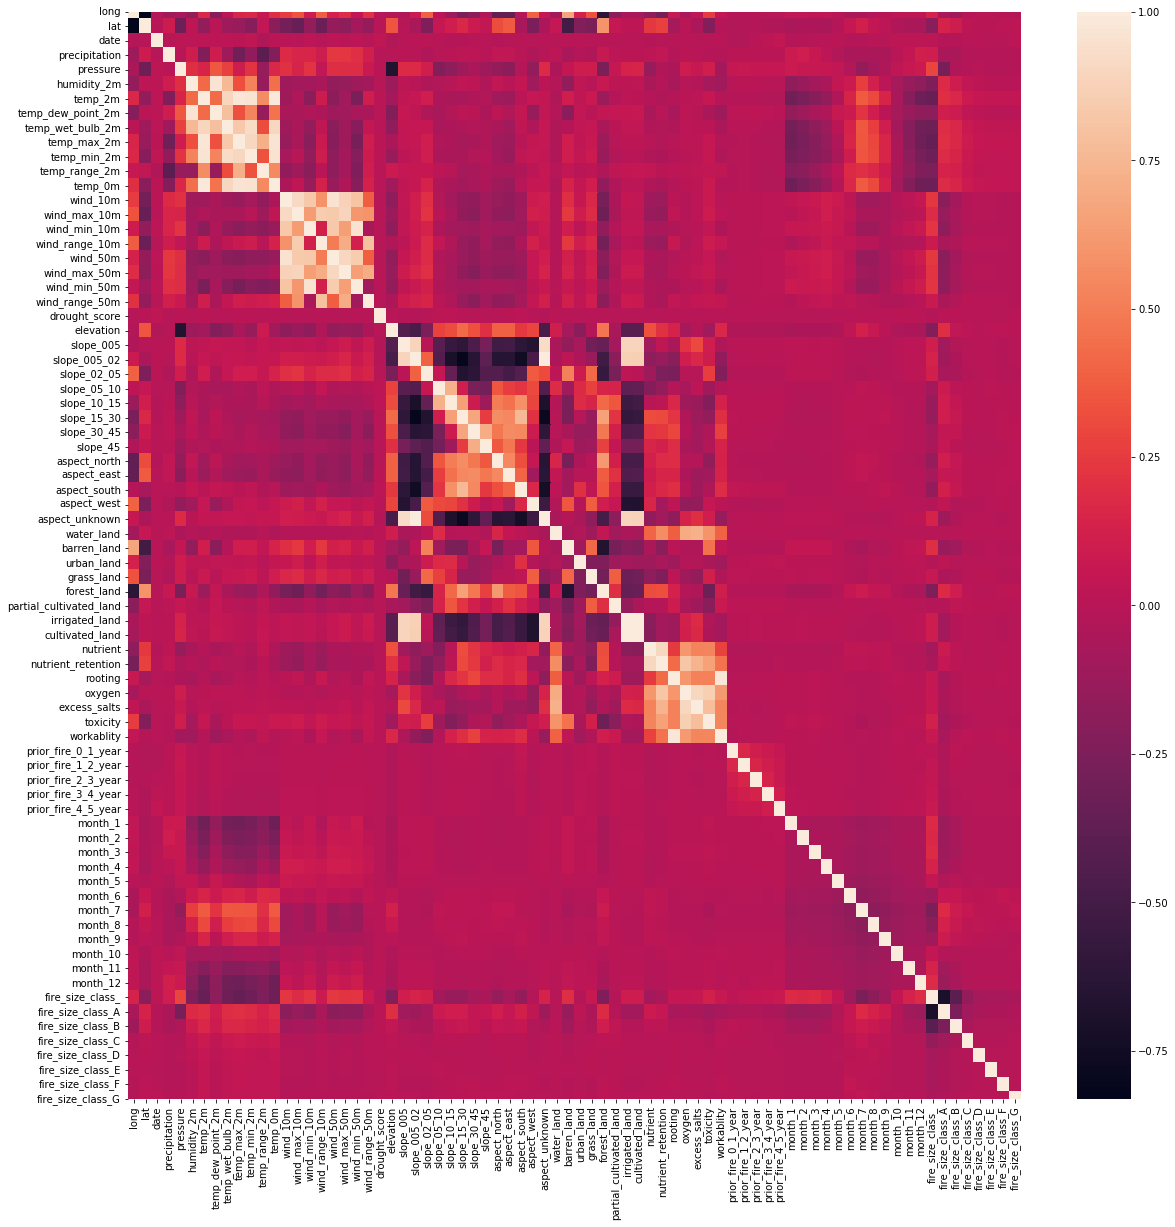

In [5]:
df_fires_corr = pd.get_dummies(df_fires, columns=['month', 'fire_size_class'])

plt.figure(figsize=(20, 20))
sns.heatmap(df_fires_corr.corr())

### All Fire Sizes (A-G)

##### LogisticRegression

In [6]:
params={
  'C': [0.1],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X_train, y_train)

print(f'All size fires estimator', log_reg.best_estimator_)

y_pred_log_reg = log_reg.predict(X_test)

print('--------- Log Regression Classification ---------')
print(classification_report(y_test, y_pred_log_reg))

All size fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.81      0.77      0.79     25072
        True       0.76      0.80      0.78     23093

    accuracy                           0.78     48165
   macro avg       0.78      0.78      0.78     48165
weighted avg       0.78      0.78      0.78     48165



In [7]:
from sklearn.ensemble import RandomForestClassifier

# params = {
#     'n_estimators': np.arange(40, 100, 20),
#     'max_features': np.arange(4, 12, 1),
#     'max_depth': np.arange(10, 20, 2),
#     'min_samples_split': np.arange(4, 12, 2),
#     'min_samples_leaf': np.arange(2, 10, 2),
#     'max_leaf_nodes': np.arange(4, 10, 2),
# }
# For performance hardcode the latest best guess
params = {'n_estimators': [40], 'min_samples_split': [4], 'min_samples_leaf': [2],
          'max_leaf_nodes': [8], 'max_features': [10], 'max_depth': [18]}

rand_forest = GridSearchCV(RandomForestClassifier(), params, scoring="recall")

rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

Best Params {'max_depth': 18, 'max_features': 10, 'max_leaf_nodes': 8, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 40}
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.76      0.79      0.78     25072
        True       0.76      0.73      0.75     23093

    accuracy                           0.76     48165
   macro avg       0.76      0.76      0.76     48165
weighted avg       0.76      0.76      0.76     48165



Text(0.5, 1.0, 'Random Forest feature importances')

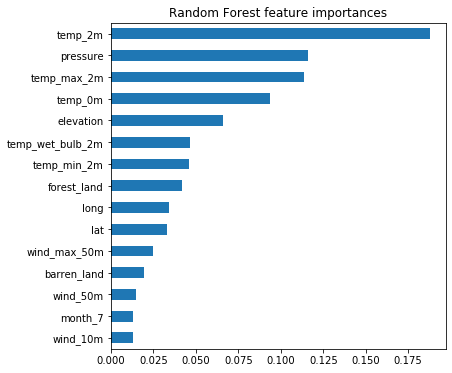

In [8]:
importances_rand_forest = rand_forest.best_estimator_.feature_importances_
importances_rand_forest = pd.Series(importances_rand_forest, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_rand_forest.plot.barh(ax=ax)
ax.set_title('Random Forest feature importances')

In [14]:
import xgboost

params={
  'objective': ['binary:logistic'],
  'max_depth': np.arange(3, 12, 3),
  'gamma': np.arange(0.1, 0.9, 0.1),
  'colsample_bytree': np.arange(0.2, 0.6, 0.2),
  'learning_rate': np.arange(0.1, 0.9, 0.1),
  'n_estimators': [200],
  'eval_metric': ['logloss']
}
# For performance hardcode the latest best guess
# params={
#   'objective': ['binary:logistic'],
#   'max_depth': [9],
#   'gamma':[0.2],
#   'learning_rate': [0.2],
#   'n_estimators': [200],
#   'colsample_bytree': [0.4],
#   'eval_metric': ['logloss']
# }

xgb = xgboost.XGBClassifier(seed=42, use_label_encoder=False)

xgb = RandomizedSearchCV(xgb, params, scoring="recall", cv=3)

xgb.fit(X_train, y_train)

print("Best Params:", xgb.best_params_)

Best Params: {'objective': 'binary:logistic', 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0.2, 'eval_metric': 'logloss', 'colsample_bytree': 0.4}


In [15]:
y_pred_xgb = xgb.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       0.88      0.85      0.87     25072
        True       0.84      0.88      0.86     23093

    accuracy                           0.86     48165
   macro avg       0.86      0.86      0.86     48165
weighted avg       0.86      0.86      0.86     48165



Text(0.5, 1.0, 'XGBoost feature importances')

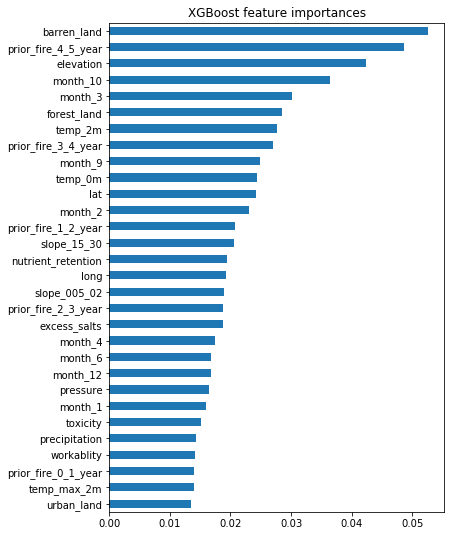

In [16]:
importances_xgb = xgb.best_estimator_.feature_importances_
importances_xgb = pd.Series(importances_xgb, index=df_fires_encoded.columns.values).sort_values().tail(30)

fig, ax = plt.subplots()
fig.set_figheight(9)
importances_xgb.plot.barh(ax=ax)
ax.set_title('XGBoost feature importances')

In [17]:
from dtreeviz import trees 

feat_cols = df_fires_encoded.columns.to_list()
trees.dtreeviz(xgb.best_estimator_, X, y, feat_cols, 'Yes Fire', class_names=[0, 1], tree_index=1)

In [ ]:
import datetime

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(df_fires, df_fires.fire_size_class > '', random_state=42)
X_orig_test = X_orig_test.reset_index(drop=True)
proba_xgb = pd.DataFrame(xgb.predict_proba(X_test), columns=['no_fire', 'yes_fire'])
proba_xgb = pd.concat([X_orig_test, proba_xgb], axis=1)
proba_xgb['yes_fire'] = proba_xgb.yes_fire * 100
proba_xgb = proba_xgb.drop(columns=proba_xgb.columns.difference(['long', 'lat', 'month', 'yes_fire']))
proba_month = proba_xgb.groupby(['long', 'lat', 'month']).mean().reset_index().sort_values('yes_fire')

fig = plt.figure(figsize=(20, 30))

for i in range(1, 13):
    ax = plt.subplot(4, 3, i)
    mon = datetime.datetime.strptime(str(i), "%m").strftime("%b")

    plt.title(f'Probability of a Fire {mon}')
    sns.scatterplot(x='long', y='lat', data=proba_month[proba_month.month == i], palette='Reds', hue='yes_fire')

In [9]:
gbm = lgbm.LGBMClassifier()

params = {
  'objective': ['binary'],
  'metric': ['binary_logloss'],
  'learning_rate': [0.01, 0.2, 0.4],
  'num_leaves': [20, 40, 100, 500, 1000, 5000],
  'max_depth': np.arange(3, 12, 1),
  'min_data_in_leaf': np.arange(200, 2000, 200),
  'max_bin': [200, 300],
  'feature_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_freq': [1, 2, 5],
}

# For performance use the best params
# params = {'objective': ['binary'], 'num_leaves': [5000], 'min_data_in_leaf': [800], 'metric': ['binary_logloss'], 'max_depth': [6],
#           'max_bin': [200], 'learning_rate': [0.8], 'feature_fraction': [0.2], 'bagging_freq': [1], 'bagging_fraction': [0.7]}

gbm = RandomizedSearchCV(estimator=gbm, param_distributions=params, scoring="recall", cv=3)
gbm.fit(X_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_fraction is set=0.8000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000000000000003
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_fraction is set=0.8000000000000003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8000000000000003
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: baggi

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'bagging_freq': [1, 2, 5],
                                        'feature_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.01, 0.2, 0.4],
                                        'max_bin': [200, 300],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'metric': ['binary_logloss'],
                                        'min_data_in_leaf': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
                                        'num_leaves': [20, 40, 100, 500, 1000,
                                                       5000],
                                        'objective': ['binary']},
                   scoring='recall')

In [10]:
print(f'Best params: {gbm.best_params_}')

y_pred_gbm = gbm.predict(X_test)

print('--------- LightGBM Classification Report ---------')
print(classification_report(y_test, y_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 100, 'min_data_in_leaf': 200, 'metric': 'binary_logloss', 'max_depth': 6, 'max_bin': 200, 'learning_rate': 0.4, 'feature_fraction': 0.7000000000000002, 'bagging_freq': 5, 'bagging_fraction': 0.6000000000000001}
--------- LightGBM Classification Report ---------
              precision    recall  f1-score   support

       False       0.86      0.83      0.85     25072
        True       0.82      0.86      0.84     23093

    accuracy                           0.84     48165
   macro avg       0.84      0.84      0.84     48165
weighted avg       0.84      0.84      0.84     48165



Text(0.5, 1.0, 'LGBM feature importances')

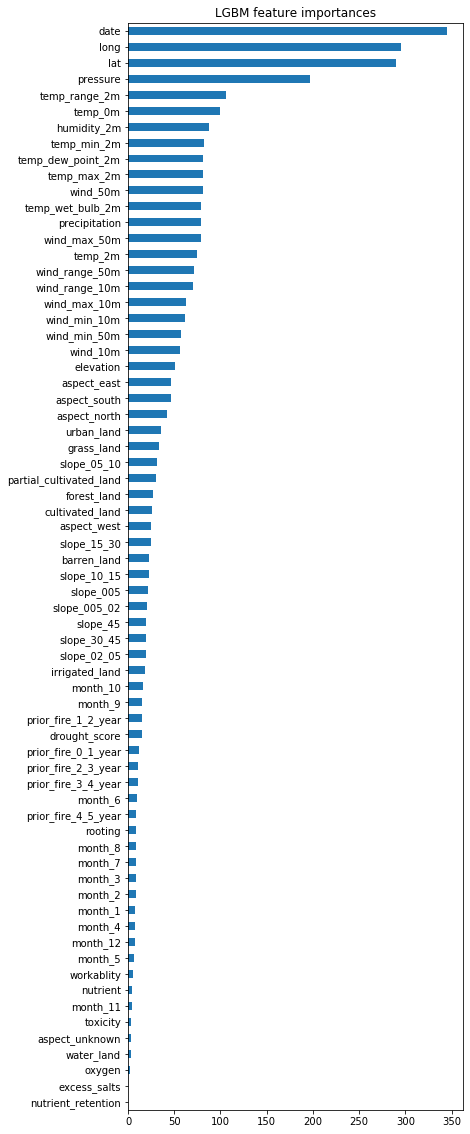

In [ ]:
importances_gbm = gbm.best_estimator_.feature_importances_
importances_gbm = pd.Series(importances_gbm, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_gbm.plot.barh(ax=ax)
ax.set_title('LGBM feature importances')